# Stellar Match: Astronomy Picture of the Day Content-Based Recommender

In [1]:
import pandas as pd
import numpy as np
import requests
import time
import os

from click import confirm
from tqdm.notebook import tqdm
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Load data
dataset_path = 'apod_data/infos.csv'

df = pd.read_csv(dataset_path, delimiter=';')
# Remove last empty column
df = df.drop(columns='Unnamed: 2')
df.drop_duplicates(subset="Title", keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

# Display basic information about the dataframe structure
print('*** Dataframe Info ***')
print(df.info())

# Show the first few rows to verify the data
print('\n*** Data Preview ***')
print(df.head())

*** Dataframe Info ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  646 non-null    int64 
 1   Title     646 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.2+ KB
None

*** Data Preview ***
   Filename                                         Title
0    150103     Apollo 17: A Stereo View from Lunar Orbit
1    150104         Crescent Rhea Occults Crescent Saturn
2    150106     100 Million Stars in the Andromeda Galaxy
3    150107  Hubble 25th Anniversary: Pillars of Creation
4    150116                        Huygens Lands on Titan


In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

API_KEY = os.getenv('NASA_API_KEY')
BASE_URL = os.getenv('APOD_BASE_URL')

if not API_KEY:
    raise ValueError("NASA_API_KEY not found. Check your .env file.")
else:
    print('NASA_API_KEY found.')

if not BASE_URL:
    raise ValueError("APOD_BASE_URL not found. Check your .env file.")
else:
    print("APOD_BASE_URL found.")

NASA_API_KEY found.
APOD_BASE_URL found.


In [4]:
def get_nasa_explanation(date_str:str):
    """
    Extract NASA Explanation from APOD API
    :param date_str: date of thr picture
    :return:
    """
    # Convert date format: YYMMDD -> YYYY-MM-DD
    formatted_date = f'20{date_str[0:2]}-{date_str[2:4]}-{date_str[4:6]}'

    params = {
        'api_key': API_KEY,
        'date': formatted_date
    }

    try:
        response = requests.get(BASE_URL, params=params)
        if response.status_code == 200:
            return response.json().get('explanation', '')
        else:
            return None
    except Exception as e:
        print(f'Error fetching date {formatted_date}: {e}')
        return None

In [5]:
# CONFIGURATION
SAVE_EVERY = 50
OUTPUT_FILE = 'apod_enriched_data.csv'

# Check if we already have a progress file to resume from
if os.path.exists(OUTPUT_FILE):
    df_progress = pd.read_csv(OUTPUT_FILE)
    start_index = len(df_progress)
    print(f'Resuming from index {start_index}...')

    # Load the original data but skip what's already done
    df_to_process = df.iloc[start_index:]

else:
    df_progress = pd.DataFrame()
    start_index = 0
    df_to_process = df

# List to temporarily store new explanations
temp_explanations = []

print(f'Starting extraction for {len(df_to_process)} rows...')

for i, (idx,row) in enumerate(tqdm(df_to_process.iterrows(), total=df_to_process.shape[0], desc="Fetching NASA data"), 1):
    # Fetch explanation using get_nasa_explanation
    explanation = get_nasa_explanation(str(row['Filename']))
    temp_explanations.append(explanation)

    # Checkpoints logic
    if i % SAVE_EVERY == 0:
        chunk_df = df.iloc[start_index + i - SAVE_EVERY : start_index + i].copy()
        chunk_df['explanation'] = temp_explanations

        mode = 'a' if os.path.exists(OUTPUT_FILE) else 'w'
        header = not os.path.exists(OUTPUT_FILE)
        chunk_df.to_csv(OUTPUT_FILE, mode=mode, header=header, index=False)

        temp_explanations = []

        time.sleep(1)

# Final save for remaining rows
if temp_explanations:
    remaining_df = df.iloc[start_index + (i - len(temp_explanations)) : start_index + i].copy()
    remaining_df['explanation'] = temp_explanations
    remaining_df.to_csv(OUTPUT_FILE, mode='a', index=False, header=False)
    print("\nProcess completed!")



Starting extraction for 646 rows...


Fetching NASA data:   0%|          | 0/646 [00:00<?, ?it/s]


Process completed!


In [6]:
df_enriched_data = pd.read_csv('apod_enriched_data.csv')
df_enriched_data.head()

,Filename,Title,explanation
0,150103,Apollo 17: A Stereo View from Lunar Orbit,Get out your red/blue glasses and check out th...
1,150104,Crescent Rhea Occults Crescent Saturn,"Soft hues, partially lit orbs, a thin trace of..."
2,150106,100 Million Stars in the Andromeda Galaxy,What stars compose the Andromeda galaxy? To b...
3,150107,Hubble 25th Anniversary: Pillars of Creation,To celebrate 25 years (1990-2015) of exploring...
4,150116,Huygens Lands on Titan,"Delivered by Saturn-bound Cassini, ESA's Huyge..."


In [7]:
# Check for missing values in each column
print('*** Missing Values Count ***')
print(df_enriched_data.isnull().sum())

*** Missing Values Count ***
Filename       0
Title          0
explanation    0
dtype: int64


In [8]:
import os
from pathlib import Path

IMAGES_DIR = Path('apod_data/APOC')

# Get the list of the names that we want to maintain
valid_filenames = {f"{str(name)}.jpg" for name in df_enriched_data["Filename"]}

# Get the list of all the files that exist in the folder
actual_files = [f.name for f in IMAGES_DIR.glob('*.jpg')]

# Indentify the files they are in the folder but not in the DataFrame
files_to_remove = [f for f in actual_files if f not in valid_filenames]

# Remove files of duplicate rows
if len(files_to_remove) > 0:
    print(f"\nExample of files to be removed: {files_to_remove[:3]}")
    confirm = input(f"Confirm deletion of {len(files_to_remove)} images? y/n")

    if confirm.lower() == 'y':
        count = 0
        for filename in files_to_remove:
            file_path = IMAGES_DIR / filename
            try:
                file_path.unlink()
                count += 1
            except Exception as e:
                print(f"Error removing {filename}: {e}")

        print(f"\nCleanup finished. {count} orphaned images removed.")
    else:
        print("\nOperation cancelled by user.")
else:
    print("\nNo cleanup needed. Your folder is already in sync with the DataFrame")


Example of files to be removed: ['191020.jpg', '180419.jpg', '210205.jpg']

Cleanup finished. 101 orphaned images removed.


In [9]:
# Fill missing values with an empty string to avoid errors during concatenation
df_enriched_data['Title'] = df_enriched_data['Title'].fillna('')
df_enriched_data['explanation'] = df_enriched_data['explanation'].fillna('')

# Combine columns into a single feature for our recommendation engine
df_enriched_data['metadata_combined'] = df_enriched_data['Title'] + " " + df_enriched_data['explanation']

# Verify the result by checking the first 5 rows of the new column
print(df_enriched_data['metadata_combined'].head())

0    Apollo 17: A Stereo View from Lunar Orbit Get ...
1    Crescent Rhea Occults Crescent Saturn Soft hue...
2    100 Million Stars in the Andromeda Galaxy What...
3    Hubble 25th Anniversary: Pillars of Creation T...
4    Huygens Lands on Titan Delivered by Saturn-bou...
Name: metadata_combined, dtype: object


In [10]:
# Load the small English model
nlp = spacy.load('en_core_web_sm')

def clean_text(text):
    """
    Lowercase, remove stopwords/punctuation, and apply lemmatization.
    """
    # 1. Process the text through the spacy pipeline
    doc = nlp(text.lower())

    # 2. Filter tokens and keep only lemmas of non-stopword/non-punctuation words
    clean_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    # 3. Join tokens back into a single string
    return " ".join(clean_tokens)

# Apply the function to our combined metadata
# Note: This might take a minute depending on the dataset size
df_enriched_data['clean_metadata'] = df_enriched_data['metadata_combined'].apply(clean_text)

print("*** Cleaned Metadata Sample ***")
print(df_enriched_data['clean_metadata'].head())

*** Cleaned Metadata Sample ***
0    apollo 17 stereo view lunar orbit red blue gla...
1    crescent rhea occults crescent saturn soft hue...
2    100 million star andromeda galaxy star compose...
3    hubble 25th anniversary pillar creation celebr...
4    huygen land titan deliver saturn bind cassini ...
Name: clean_metadata, dtype: object


In [11]:
# Initialize the vectorizer
# max_features: limits the number of words to the top N most important
tfidf = TfidfVectorizer()

# Construct the TF-IDF matrix
# This transforms our clean text into a matrix of numbers
tfidf_matrix = tfidf.fit_transform(df_enriched_data['clean_metadata'])

print(f'Matrix shape: {tfidf_matrix.shape}')

Matrix shape: (646, 5531)


In [12]:
# Compute the cosine similarity matrix
# This compares every image vector against every other image vector
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(f'Similarity matrix shape: {cosine_sim.shape}')

Similarity matrix shape: (646, 646)


In [13]:
# Create a helper to map titles to their dataframe index
# This allows us to search for a title and get its position (0, 1, 2...)
indices = pd.Series(df_enriched_data.index, index=df_enriched_data['Title']).drop_duplicates()

In [14]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # 1. Get the index of the image that matches the title
    idx_entry = indices[title]

    if isinstance(idx_entry, pd.Series):
        idx = idx_entry.iloc[0]
    else:
        idx = idx_entry

    # 2. Get the pairwise similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))

    # 3. Sort by similarity score in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 4. Get the top 3 most similar images (excluding the first one)
    sim_scores = sim_scores[1:6]

    # 5. Get the indices
    image_indices = [i[0] for i in sim_scores]

    # 6. Return a slice of the dataframe with relevant info
    return df_enriched_data[['Title', 'Filename', 'explanation']].iloc[image_indices]

In [15]:
# Test the system with a specific object
test_title = 'Southern Jupiter from Perijove 3'
recommendations = get_recommendations(test_title)

print(f'Recommendations for: {test_title}\n')
print(recommendations[['Title', 'Filename']])

Recommendations for: Southern Jupiter from Perijove 3

                                          Title  Filename
274                            Perijove Passage    170603
288              Close-up of The Great Red Spot    170715
241     A White Oval Cloud on Jupiter from Juno    170228
639     Giant Storms and High Clouds on Jupiter    211229
198  Clouds Near Jupiter's South Pole from Juno    161025


### 👀 Sanity Check
The script below will take an image from the dataset, search for its five recommendations, and display them in a row so that their content can be visually compared.

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def visual_sanity_check(title, folder_path='apod_data/APOC'):
    # Get recommendations
    recommendations = get_recommendations(title)

    # Get filename from dataset
    original_filename = df_enriched_data[df_enriched_data['Title'] == title]['Filename'].values[0]

    rec_filenames = recommendations['Filename'].tolist()
    filenames = [original_filename]
    filenames.extend(rec_filenames)
    titles = [f"ORIGINAL:\n{title}"]
    titles.extend([f"Rec {i+1}:\n{t}" for i, t in enumerate(recommendations['Title'])])

    # Get picture paths
    '''filenames = [original_filename] + list[recommendations['Filename']]
    titles = [f"ORIGINAL:\n{title}"] + [f"Rec {i+1}:\n{t}" for i, t in enumerate(recommendations['title'])]'''

    # Configure visualization
    fig, axes = plt.subplots(1, 6, figsize=(22, 7))

    for i, (fname, t) in enumerate(zip(filenames, titles)):
        img_path = os.path.join(folder_path, str(fname) + '.jpg')

        try:
            if os.path.exists(img_path):
                img = Image.open(img_path)
                axes[i].imshow(img)
                color = 'yellow' if i == 0 else 'black'
                axes[i].set_title(t[:25] + "...", fontsize=10, color=color, fontweight='bold' if i==0 else 'normal')
            else:
                axes[i].text(0.5, 0.5, f'File not found:\n{fname}', ha='center', fontsize=8)

        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error loading image', ha='center')

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

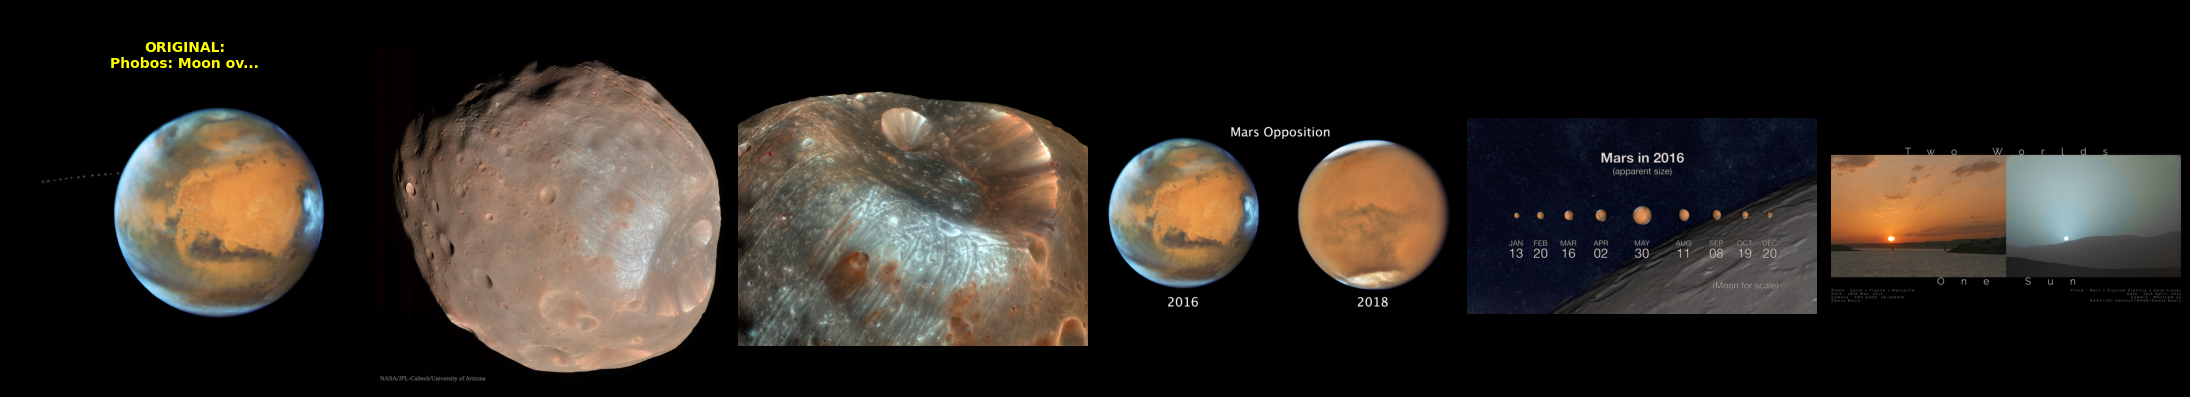

In [17]:
visual_sanity_check('Phobos: Moon over Mars')

### ⚖️ Evaluating Recommendation Diversity

In a content-based recommendation system, **Relevance** is only half of the story. To provide a high-quality user experience, we must also measure **Diversity**. A system that only recommends identical items can create a "filter bubble," limiting the user's discovery of the cosmos.

**Diversity Calculation Logic:**
* **Intra-List Similarity:** We calculate the average **Cosine Similarity** between all pairs of recommended items within the top-5 list.
* **Mathematical Approach:** Diversity is defined as $1 - \text{Average Similarity}$.
* **Scoring Interpretation:**
    * **High Diversity (~1.0):** The recommendations are very different from each other (e.g., a planet, a nebula, and a galaxy).
    * **Low Diversity (~0.0):** The recommendations are redundant (e.g., five different photos of the same Saturn rings).

This metric helps us tune the `TF-IDF` parameters and the number of features to find the "sweet spot" between thematic consistency and serendipitous discovery.

In [18]:
def calculate_diversity(recommendations_indices, tfidf_matrix) -> float:
    """
    Calculate the diversity of recommended items.
    1.0 means maximum diversity, 0.0 means all items are identical
    :param recommendations_indices:
    :param tfidf_matrix:
    :return diversity_score:
    """
    # Get the vectors for the recommended images
    vectors = tfidf_matrix[recommendations_indices]

    # Calculate the similarity matrix between the recommended items
    inner_sim = cosine_similarity(vectors)

    # Avoid self-similarity
    upper_triangle_indices = np.triu_indices(inner_sim.shape[0], k=1)
    avg_sim = np.mean(inner_sim[upper_triangle_indices])

    # Calculate diversity
    diversity_score = 1 - avg_sim

    return diversity_score

### 🧪 Automated Stress Test - Validating Strict Accuracy

To ensure the recommendation engine consistently delivers highly relevant results, we perform an automated **Stress Test**. By sampling random entries from the dataset, we can observe how the model behaves across different astronomical categories (e.g., galaxies, nebulae, planetary missions).

**Objective:**
Since our primary goal is **Strict Accuracy**, we expect to see relatively low diversity scores in this test. This confirms that the engine is successfully grouping items with high semantic overlap, providing the user with specialized content rather than generic variety.

**Test Workflow:**
1.  **Random Sampling:** Select $N$ random images from the processed dataset.
2.  **Batch Recommendation:** Generate the top-5 most similar items for each sample.
3.  **Metrics Aggregation:** Calculate the average diversity across all samples to establish a system-wide baseline.

*By monitoring the 'Overall System Average Diversity', we can fine-tune our TF-IDF thresholds to maintain the delicate balance between thematic precision and meaningful discovery.*

In [19]:
import random

def run_stress_test(n_samples=10):
    """
    Selects random images and calculates the average diversity
    :param n_samples:
    :return:
    """
    results = []

    # Pick n random titles from our index

    sample_titles = random.sample(list(indices.index), n_samples)

    print(f'*** Running Stress Test on {n_samples} samples ***')

    for title in sample_titles:
        # Get recommendations
        recs = get_recommendations(title)
        rec_indices = []
        for t in recs['Title']:
            idx_val = indices[t]
            if isinstance(idx_val, pd.Series):
                rec_indices.append(idx_val.iloc[0])
            else:
                rec_indices.append(idx_val)
        # rec_indices = [indices[t] for t in recs['Title']]

        # Calculate diversity
        div_score = calculate_diversity(rec_indices, tfidf_matrix)
        results.append(div_score)

        print(f'Title: {title[:40]}... | Diversity: {div_score: .4f}')

    avg_diversity = np.mean(results)
    print(f'Overall Diversity: {avg_diversity: .4f}')
    print(f'Lower scores indicate higher Strict accuracy')

# Run test
run_stress_test(5)

*** Running Stress Test on 5 samples ***
Title: Hubble's Jupiter and the Shrinking Great... | Diversity:  0.7538
Title: The Tadpole Galaxy from Hubble... | Diversity:  0.8369
Title: Herbig-Haro 24... | Diversity:  0.7976
Title: Cylindrical Mountains on Venus... | Diversity:  0.6768
Title: In, Through, and Beyond Saturn's Rings... | Diversity:  0.5416
Overall Diversity:  0.7213
Lower scores indicate higher Strict accuracy


In [20]:
import pickle

# Create dictionary to wrap tha data
model_data = {
    'dataframe': df_enriched_data,
    'cosine_sim': cosine_sim,
    'indices': indices
}

# Save Dictionary into a file
with open('stellarmatch_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model exported correctly!")

Model exported correctly!
